In [1]:
!git clone https://gitlab.com/lambda-hse/gans_coursera_public
%cd gans_coursera_public
from grading import Grader
from utils import weights_init
parts = ['aHqqo', 'PbZ0M', '2eEzO']
grader = Grader('V9LoaEk2SVWL3gsFPmqgAw', parts)
%cd ..

Cloning into 'gans_coursera_public'...
remote: Enumerating objects: 88, done.
remote: Total 88 (delta 0), reused 0 (delta 0), pack-reused 88
Receiving objects: 100% (88/88), 6.35 MiB | 4.69 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/gans_coursera_public
/content


In [ ]:
COURSERA_EMAIL, COURSERA_TOKEN = ??? # PASTE YOUR COURSERA EMAIL AND ASSIGNMENT TOKEN HERE

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"}) # Download Celeba dataset
downloaded.GetContentFile('img_align_celeba.zip') , 1, 1

(None, 1, 1)

In [6]:
!pwd
!unzip img_align_celeba.zip  -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: /content/img_align_celeba/197600.jpg  
 extracting: /content/img_align_celeba/197601.jpg  
 extracting: /content/img_align_celeba/197602.jpg  
 extracting: /content/img_align_celeba/197603.jpg  
 extracting: /content/img_align_celeba/197604.jpg  
 extracting: /content/img_align_celeba/197605.jpg  
 extracting: /content/img_align_celeba/197606.jpg  
 extracting: /content/img_align_celeba/197607.jpg  
 extracting: /content/img_align_celeba/197608.jpg  
 extracting: /content/img_align_celeba/197609.jpg  
 extracting: /content/img_align_celeba/197610.jpg  
 extracting: /content/img_align_celeba/197611.jpg  
 extracting: /content/img_align_celeba/197612.jpg  
 extracting: /content/img_align_celeba/197613.jpg  
 extracting: /content/img_align_celeba/197614.jpg  
 extracting: /content/img_align_celeba/197615.jpg  
 extracting: /content/img_align_celeba/197616.jpg  
 extracting: /content/img_align_celeba/197617.jp

# Data load

CelebA dataset with faces will be used

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])

In [8]:
# check the path to images
!ls /content/img_align_celeba/

Выходные данные были обрезаны до нескольких последних строк (5000).
020326.jpg  045651.jpg	070976.jpg  096301.jpg	121626.jpg  146951.jpg	172276.jpg  197601.jpg
020327.jpg  045652.jpg	070977.jpg  096302.jpg	121627.jpg  146952.jpg	172277.jpg  197602.jpg
020328.jpg  045653.jpg	070978.jpg  096303.jpg	121628.jpg  146953.jpg	172278.jpg  197603.jpg
020329.jpg  045654.jpg	070979.jpg  096304.jpg	121629.jpg  146954.jpg	172279.jpg  197604.jpg
020330.jpg  045655.jpg	070980.jpg  096305.jpg	121630.jpg  146955.jpg	172280.jpg  197605.jpg
020331.jpg  045656.jpg	070981.jpg  096306.jpg	121631.jpg  146956.jpg	172281.jpg  197606.jpg
020332.jpg  045657.jpg	070982.jpg  096307.jpg	121632.jpg  146957.jpg	172282.jpg  197607.jpg
020333.jpg  045658.jpg	070983.jpg  096308.jpg	121633.jpg  146958.jpg	172283.jpg  197608.jpg
020334.jpg  045659.jpg	070984.jpg  096309.jpg	121634.jpg  146959.jpg	172284.jpg  197609.jpg
020335.jpg  045660.jpg	070985.jpg  096310.jpg	121635.jpg  146960.jpg	172285.jpg  197610.jpg
020336.jpg  

In [9]:
CELEBA_PATH = "/content/img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img


full_dataset = CelebA(CELEBA_PATH, transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True)

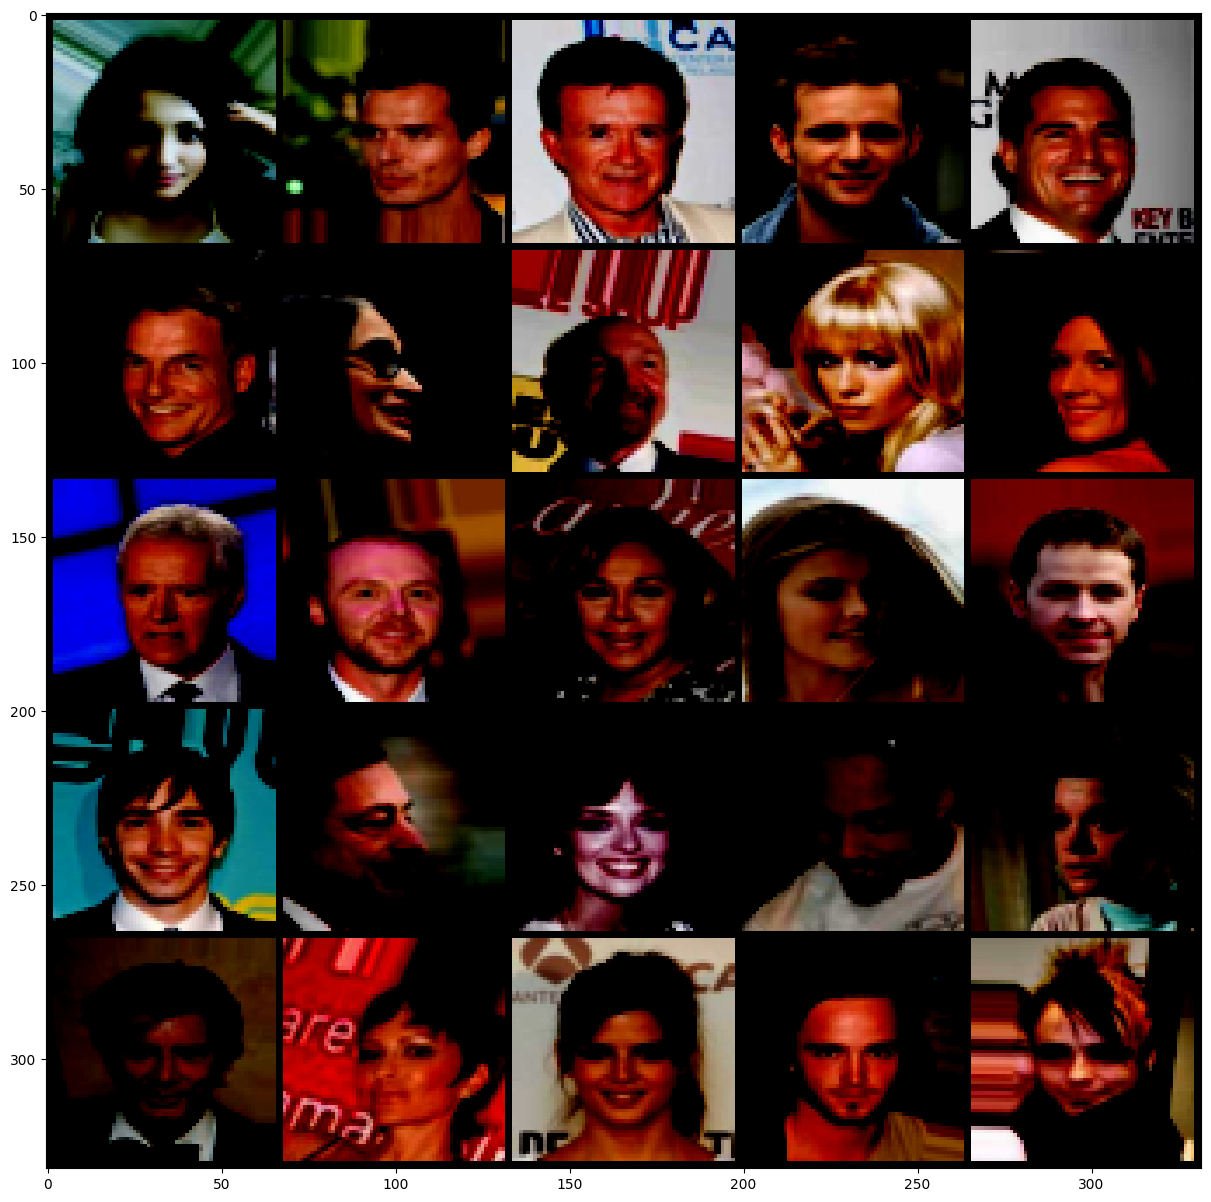

In [10]:
from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

# WGAN

<center>

Earth Mover Distance (EMD, Wasserstein) distance illustration

![](https://qph.fs.quoracdn.net/main-qimg-b579b7e100750529c32e9f209f53f8a1.webp)

![](https://miro.medium.com/max/800/1*NPxy6I_x1FuGHfIXN4TVyw.png)


<!-- ![](https://miro.medium.com/max/403/1*B47z2jEUNI65-ArwEVnFHw.png) -->

Formula

![](https://slideplayer.com/slide/9533415/30/images/21/%28Wasserstein+distance%29.jpg)

**It is intractable!**

Instead, equivalent form of wassertein distance (Kantorovich-rubinstein duality) is used

![](https://miro.medium.com/max/3028/1*6y-tz57odJpHh4pwRfXACw.png)

</center>

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        ??? # YOUR CODE HERE. Implement standard generator like in previous assignment

    def forward(self, x):
        ??? # YOUR CODE HERE


class Discriminator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super().__init__()
        ??? # YOUR CODE HERE. Implement standard discriminator like in previous assignment. There is no need in sigmoid activation anymore!

    def forward(self, x):
        ??? # YOUR CODE HERE

In [ ]:
z_dim = 100
img_dim = 3

D = Discriminator(img_dim).to(device)
G = Generator(z_dim).to(device)

[model.apply(weights_init) for model in [D,G]] # Weights initialization

d_optimizer = torch.optim.AdamW(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.AdamW(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
batches_done = 0
n_epochs = 1
n_critic = 2

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
  for epoch in range(n_epochs):
      for i, imgs in enumerate(dataloader):
          ??? # YOUR CODE HERE
          # All the training process is the same instead of objective. Minimize wasserstein distance between real and fake images instead! (use Kantorovich-Rubinstein duality - f is discriminator in that notation)

<ipython-input-22-53272e0f5092>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


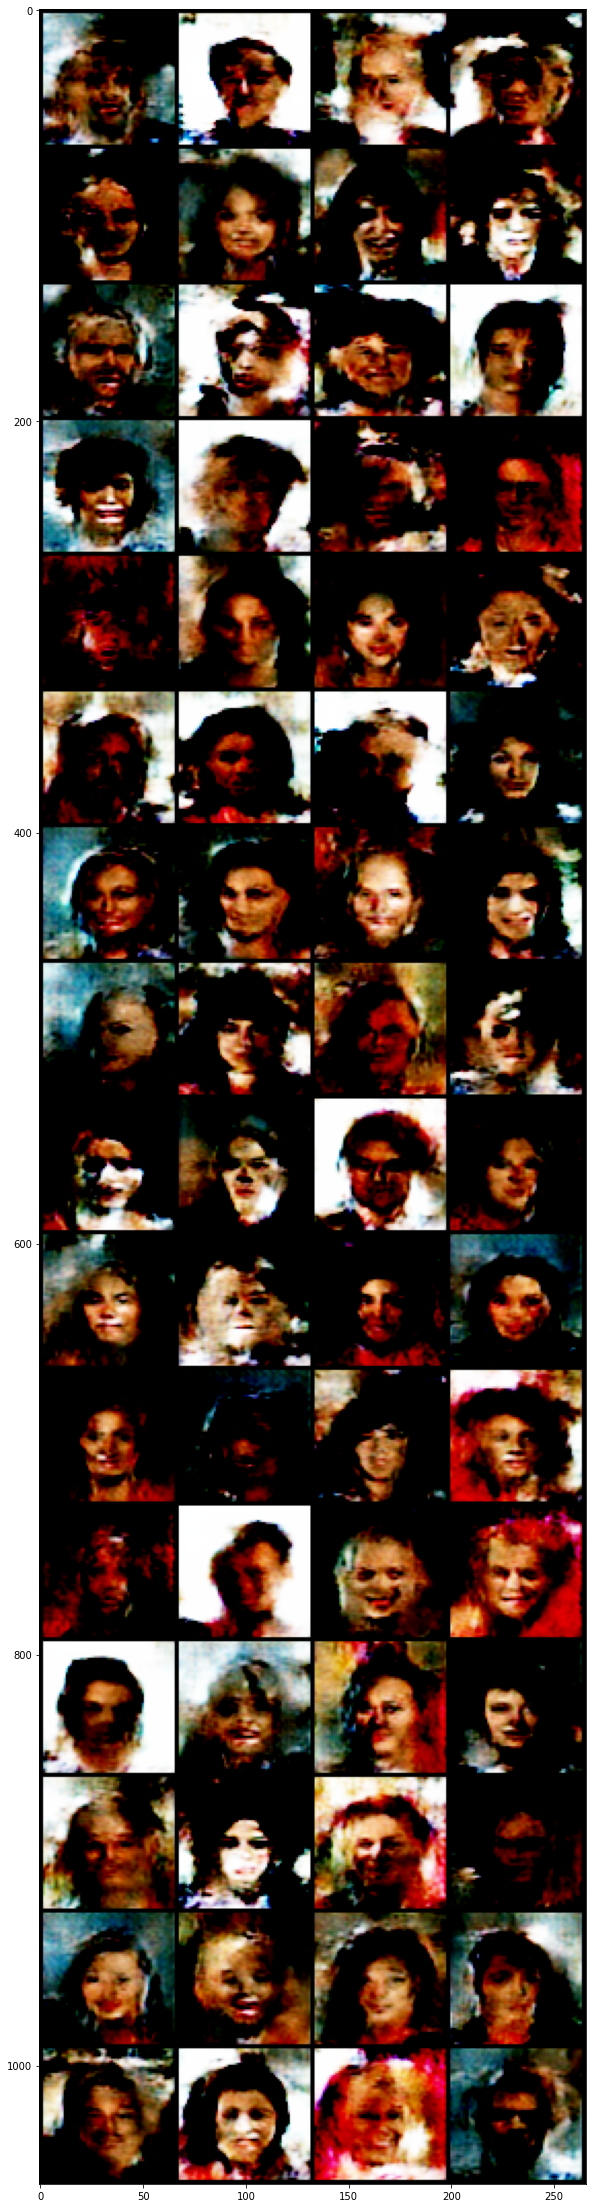

In [ ]:
# Generated images
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

## Visual

In [ ]:
!pip install lpips

In [ ]:
### GRADED PART. DO NOT CHANGE!!!
import seaborn as sns
import lpips
# define as a criterion module (recommended)
test_fn = lpips.LPIPS(net='vgg')

distances = [] #
n_steps = [3,10]

for j in n_steps:
  for i, image in tqdm(enumerate(dataloader), total=j):
    if i > j: break
    with torch.no_grad():
      generated = G(torch.randn(image.shape[0],z_dim,device=device)).detach().to('cpu')
      for d in test_fn(generated, image.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
        distances.append(d)

<ipython-input-26-aa8146d8122f>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image in tqdm(enumerate(dataloader), total=n_steps):


In [ ]:
grader.set_answer(parts[0], np.mean(distances))

# WGAN-GP

<center>

![](https://miro.medium.com/max/3028/1*6y-tz57odJpHh4pwRfXACw.png)

</center>

Idea: let's try to ensure 1-Lipschitz property of discriminator $f$ by gradient penalty (all gradients of the discriminator must be close to 1)

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(real_samples.shape[0], requires_grad=False, device=device), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
z_dim = 100
img_dim = 3

# All the networks are the same! Only gradient penalty will be added
D = Discriminator(img_dim).to(device)
G = Generator(z_dim).to(device)

[model.apply(weights_init) for model in [D,G]]

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
lambda_gp = 10
batches_done = 0
n_epochs = 50
n_critic = 5

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:

  for epoch in range(n_epochs):
      for i, imgs in enumerate(dataloader):
          # Train WGAN with gradient penalty term
          ??? # YOUR CODE HERE

<ipython-input-34-9f2e19cc477a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


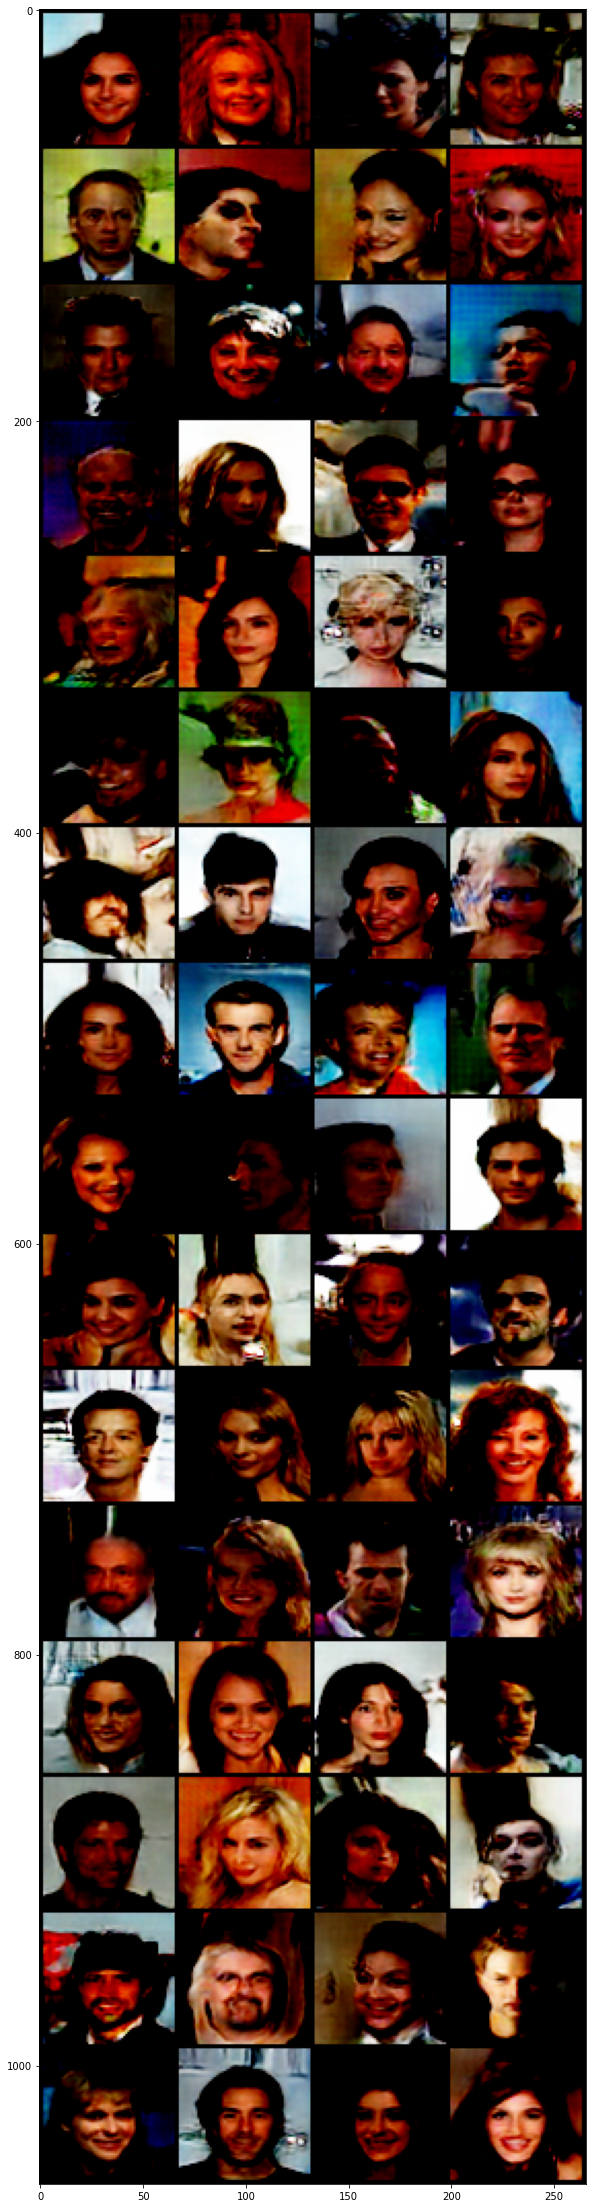

In [ ]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

## Visual

In [ ]:
### GRADED PART. DO NOT CHANGE!!!
import seaborn as sns
import lpips
# define as a criterion module (recommended)
test_fn = lpips.LPIPS(net='vgg')

distances = [] #
n_steps = [3,10]

for j in n_steps:
  for i, image in tqdm(enumerate(dataloader), total=j):
    if i > j: break
    with torch.no_grad():
      generated = G(torch.randn(image.shape[0],z_dim,device=device)).detach().to('cpu')
      for d in test_fn(generated, image.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
        distances.append(d)


grader.set_answer(parts[1], np.mean(distances))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/dl/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


<ipython-input-36-c000b1f21dd2>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image in tqdm(enumerate(dataloader), total=n_steps):


# Spectral normalization

By definition, Lipschitz norm $||g||_{Lip}$ is equal to $sup_h \sigma(∇g(h))$, where $\sigma(A)$ is the spectral norm of the matrix A (L2 matrix norm of A):

$$\sigma(A)=max_{h\neq0}\frac{||Ah||_2}{||h||_2}=max_{||h||_2\leq1}||Ah||_2$$

Thus, for any L-Lipschitz $g(\cdot)$ we can obtain 1-Lipschitz $\tilde{g}(\cdot)=\frac{g(\cdot)}{\sigma(g)}$ just by applying spectral normalization for layers

In [ ]:
from torch.nn.utils import spectral_norm as SpectralNorm

??? # YOUR CODE HERE
# Implement disriminator (DiscriminatorSN) with spectral normalization to make it 1-Lipschitz

In [ ]:
z_dim = 100
img_dim = 3

D = DiscriminatorSN(img_dim).to(device)
G = Generator(z_dim).to(device)
[model.apply(weights_init) for model in [D,G]]

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
batches_done = 0
n_epochs = 50
n_critic = 2

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:

  for epoch in range(n_epochs):
      for i, imgs in enumerate(dataloader):
          # Train networks with Wasserstein loss as before
          ??? # YOUR CODE HERE


<ipython-input-118-2b716ceddf8c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:


In [ ]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(fake_imgs, nrow=4).detach().cpu().permute(1,2,0))

## Visual

In [ ]:
### GRADED PART. DO NOT CHANGE!!!
### GRADED PART. DO NOT CHANGE!!!
import seaborn as sns
import lpips
# define as a criterion module (recommended)
test_fn = lpips.LPIPS(net='vgg')

distances = [] #
n_steps = [3,10]

for j in n_steps:
  for i, image in tqdm(enumerate(dataloader), total=j):
    if i > j: break
    with torch.no_grad():
      generated = G(torch.randn(image.shape[0],z_dim,device=device)).detach().to('cpu')
      for d in test_fn(generated, image.to('cpu')).squeeze().detach().numpy().tolist(): # measure distances between real and generated images
        distances.append(d)


grader.set_answer(parts[2], np.mean(distances))

In [ ]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# References

* https://github.com/eriklindernoren/PyTorch-GAN - Lots of different GAN implementations
* https://arxiv.org/abs/1704.00028 - WGAN(-GP)
* https://arxiv.org/abs/1802.05957 - Spectral Normalization
* https://becominghuman.ai/all-about-normalization-6ea79e70894b - Instance-, Batch- and other normalizations
* https://github.com/Lornatang/CycleGAN-PyTorch - CycleGAN (StyleTransfer)
* https://distill.pub/2016/deconv-checkerboard/ - resize upsampling and checkerboard problem